In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e12/sample_submission.csv
/kaggle/input/playground-series-s4e12/train.csv
/kaggle/input/playground-series-s4e12/test.csv


In [14]:
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# import seaborn as sns
# import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [4]:
df = pd.read_csv("/kaggle/input/playground-series-s4e12/train.csv")
# df.head()

In [17]:
df_test = pd.read_csv("/kaggle/input/playground-series-s4e12/test.csv")
df_test.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
0,1200000,28.0,Female,2310.0,NaN,4.0,Bachelor's,Self-Employed,7.657981,Rural,Basic,NaN,19.0,NaN,1.0,2023-06-04 15:21:39.245086,Poor,Yes,Weekly,House
1,1200001,31.0,Female,126031.0,Married,2.0,Master's,Self-Employed,13.381379,Suburban,Premium,NaN,14.0,372.0,8.0,2024-04-22 15:21:39.224915,Good,Yes,Rarely,Apartment
2,1200002,47.0,Female,17092.0,Divorced,0.0,PhD,Unemployed,24.354527,Urban,Comprehensive,NaN,16.0,819.0,9.0,2023-04-05 15:21:39.134960,Average,Yes,Monthly,Condo
3,1200003,28.0,Female,30424.0,Divorced,3.0,PhD,Self-Employed,5.136225,Suburban,Comprehensive,1.0,3.0,770.0,5.0,2023-10-25 15:21:39.134960,Poor,Yes,Daily,House
4,1200004,24.0,Male,10863.0,Divorced,2.0,High School,Unemployed,11.844155,Suburban,Premium,NaN,14.0,755.0,7.0,2021-11-26 15:21:39.259788,Average,No,Weekly,House


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

In [19]:
df.describe().round(1)

,id,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount
count,1200000.0,1181295.0,1155051.0,1090328.0,1125924.0,835971.0,1199994.0,1062118.0,1199999.0,1200000.0
mean,599999.5,41.1,32745.2,2.0,25.6,1.0,9.6,592.9,5.0,1102.5
std,346410.3,13.5,32179.5,1.4,12.2,1.0,5.8,150.0,2.6,865.0
min,0.0,18.0,1.0,0.0,2.0,0.0,0.0,300.0,1.0,20.0
25%,299999.8,30.0,8001.0,1.0,15.9,0.0,5.0,468.0,3.0,514.0
50%,599999.5,41.0,23911.0,2.0,24.6,1.0,10.0,595.0,5.0,872.0
75%,899999.2,53.0,44634.0,3.0,34.5,2.0,15.0,721.0,7.0,1509.0
max,1199999.0,64.0,149997.0,4.0,59.0,9.0,19.0,849.0,9.0,4999.0


In [20]:
df.isna().sum()

id                           0
Age                      18705
Gender                       0
Annual Income            44949
Marital Status           18529
Number of Dependents    109672
Education Level              0
Occupation              358075
Health Score             74076
Location                     0
Policy Type                  0
Previous Claims         364029
Vehicle Age                  6
Credit Score            137882
Insurance Duration           1
Policy Start Date            0
Customer Feedback        77824
Smoking Status               0
Exercise Frequency           0
Property Type                0
Premium Amount               0
dtype: int64

<Axes: >

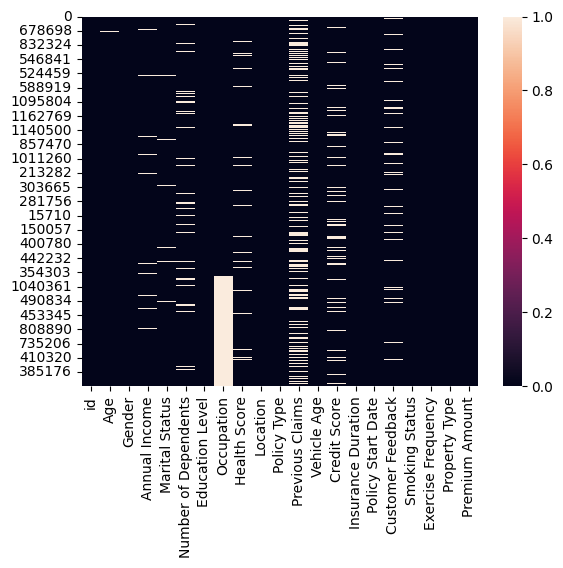

In [21]:
sns.heatmap(df.isna().sort_values(by=["Occupation"]) == True)

In [5]:
df.dropna(inplace = True)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(df.select_dtypes(exclude = "object").corr(), annot = True, cmap = "Reds")

<Axes: >

In [24]:
df_categorical = df.select_dtypes('object')
for object_column in df_categorical.columns:
    print(object_column, {df[object_column].nunique()}, ': ', df[object_column].unique(), '\n')

Gender {2} :  ['Female' 'Male'] 

Marital Status {3} :  ['Married' 'Single' 'Divorced'] 

Education Level {4} :  ["Bachelor's" 'High School' "Master's" 'PhD'] 

Occupation {3} :  ['Self-Employed' 'Employed' 'Unemployed'] 

Location {3} :  ['Urban' 'Rural' 'Suburban'] 

Policy Type {3} :  ['Premium' 'Comprehensive' 'Basic'] 

Policy Start Date {131804} :  ['2023-12-23 15:21:39.134960' '2021-12-01 15:21:39.252145'
 '2022-08-08 15:21:39.181605' ... '2019-11-14 15:21:39.201446'
 '2021-10-09 15:21:39.220389' '2019-12-06 15:21:39.133866'] 

Customer Feedback {3} :  ['Poor' 'Average' 'Good'] 

Smoking Status {2} :  ['No' 'Yes'] 

Exercise Frequency {4} :  ['Weekly' 'Rarely' 'Daily' 'Monthly'] 

Property Type {3} :  ['House' 'Condo' 'Apartment'] 



In [5]:
df.drop(['id', 'Policy Start Date'], axis = 1, inplace = True)

In [7]:
for non_object_column in df.select_dtypes(exclude = "object").columns:
    if non_object_column != 'Premium Amount':
        df[non_object_column] = df[non_object_column] / df[non_object_column].max()

In [8]:
df.head()

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0.296875,Female,0.066995,Married,0.25,Bachelor's,Self-Employed,0.386618,Urban,Premium,0.250,0.894737,0.438163,0.555556,Poor,No,Weekly,House,2869.0
4,0.328125,Male,0.264345,Single,0.25,Bachelor's,Self-Employed,0.348592,Rural,Premium,0.000,0.421053,0.704358,0.444444,Poor,Yes,Weekly,House,2022.0
7,0.750000,Female,0.848264,Divorced,0.50,High School,Employed,0.098709,Suburban,Comprehensive,0.125,0.578947,0.468787,0.555556,Average,No,Rarely,Condo,111.0
9,0.687500,Male,0.349654,Married,0.50,Master's,Employed,0.350263,Urban,Comprehensive,0.125,0.473684,0.747939,0.333333,Poor,No,Daily,Condo,64.0
15,0.281250,Male,0.040507,Married,0.50,High School,Employed,0.127334,Urban,Premium,0.125,0.631579,0.687868,0.555556,Good,Yes,Monthly,Apartment,849.0


In [6]:
df["Policy Start Date"] = pd.to_datetime(df["Policy Start Date"].apply(lambda x: x[:10]))

In [ ]:
pd.get_dummies(df_categorical, drop_first = True, dtype = int)

In [7]:
df = pd.concat(
    [
        df.select_dtypes(exclude = "object"), 
        pd.get_dummies(df.select_dtypes('object'), drop_first = True, dtype = int)
    ],
    axis = "columns"
)
df.head()

,id,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,...,Policy Type_Comprehensive,Policy Type_Premium,Customer Feedback_Good,Customer Feedback_Poor,Smoking Status_Yes,Exercise Frequency_Monthly,Exercise Frequency_Rarely,Exercise Frequency_Weekly,Property Type_Condo,Property Type_House
0,0,19.0,10049.0,1.0,22.598761,2.0,17.0,372.0,5.0,2023-12-23,...,0,1,0,1,0,0,0,1,0,1
4,4,21.0,39651.0,1.0,20.376094,0.0,8.0,598.0,4.0,2021-12-01,...,0,1,0,1,1,0,0,1,0,1
7,7,48.0,127237.0,2.0,5.769783,1.0,11.0,398.0,5.0,2022-08-08,...,1,0,0,0,0,0,1,0,1,0
9,9,44.0,52447.0,2.0,20.473718,1.0,9.0,635.0,3.0,2020-08-02,...,1,0,0,1,0,0,0,0,1,0
15,15,18.0,6076.0,2.0,7.442964,1.0,12.0,584.0,5.0,2020-10-17,...,0,1,1,0,1,1,0,0,0,0


In [8]:
df.dtypes

id                                      int64
Age                                   float64
Annual Income                         float64
Number of Dependents                  float64
Health Score                          float64
Previous Claims                       float64
Vehicle Age                           float64
Credit Score                          float64
Insurance Duration                    float64
Policy Start Date              datetime64[ns]
Premium Amount                        float64
Gender_Male                             int64
Marital Status_Married                  int64
Marital Status_Single                   int64
Education Level_High School             int64
Education Level_Master's                int64
Education Level_PhD                     int64
Occupation_Self-Employed                int64
Occupation_Unemployed                   int64
Location_Suburban                       int64
Location_Urban                          int64
Policy Type_Comprehensive         

In [9]:
x = df.drop(['id', 'Policy Start Date', 'Premium Amount'], axis = 1)
y = df['Premium Amount']

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

In [11]:
model1 = LinearRegression()

In [12]:
model1.fit(x_train, y_train)

LinearRegression()

In [13]:
y_pred = model1.predict(x_test)

In [14]:
def rmsle(predictions, targets):
    """Calculate the root mean squared logarithmic error between predictions and targets"""
    return np.sqrt(np.mean((np.log(predictions + 1) - np.log(targets + 1)) ** 2))

In [15]:
rmsle(y_pred, y_test)

1.1672632031660481

In [16]:
model1.fit(x, y)

LinearRegression()

In [17]:
x.shape

(384004, 28)

In [21]:
df_test = pd.read_csv("/kaggle/input/playground-series-s4e12/test.csv")

# for non_object_column in df_test.select_dtypes(exclude = "object").columns:
#     df_test[non_object_column] = df_test[non_object_column] / df_test[non_object_column].max()

df_test["Policy Start Date"] = pd.to_datetime(df_test["Policy Start Date"].apply(lambda x: x[:10]))

df_test = pd.concat(
    [
        df_test.select_dtypes(exclude = "object"), 
        pd.get_dummies(df_test.select_dtypes('object'), drop_first = True, dtype = int)
    ],
    axis = "columns"
)

x_df_test = df_test.drop(['id', 'Policy Start Date'], axis = 1)

print(x_df_test.shape)
x_df_test.head()

(255358, 28)


,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Gender_Male,Marital Status_Married,...,Policy Type_Comprehensive,Policy Type_Premium,Customer Feedback_Good,Customer Feedback_Poor,Smoking Status_Yes,Exercise Frequency_Monthly,Exercise Frequency_Rarely,Exercise Frequency_Weekly,Property Type_Condo,Property Type_House
3,28.0,30424.0,3.0,5.136225,1.0,3.0,770.0,5.0,0,0,...,1,0,0,1,1,0,0,0,0,1
10,44.0,24238.0,0.0,20.769332,0.0,11.0,408.0,3.0,1,0,...,0,1,0,1,0,0,0,0,1,0
11,63.0,5824.0,2.0,13.430514,0.0,9.0,849.0,9.0,1,0,...,1,0,1,0,1,0,0,1,0,1
13,60.0,44769.0,2.0,20.837186,1.0,14.0,621.0,4.0,1,1,...,1,0,1,0,0,0,0,1,0,0
14,46.0,66984.0,0.0,16.490747,1.0,12.0,319.0,2.0,0,0,...,0,1,0,1,0,1,0,0,0,1


In [22]:
Y_pred_test = model1.predict(x_df_test)

In [35]:
df_sub = pd.read_csv("/kaggle/input/playground-series-s4e12/sample_submission.csv")
df_sub.head()

,id,Premium Amount
0,1200000,1102.545
1,1200001,1102.545
2,1200002,1102.545
3,1200003,1102.545
4,1200004,1102.545


In [24]:
df_test['Premium Amount'] = Y_pred_test.round(3)
df_submission = df_test[['id', 'Premium Amount']]

print(df_submission.shape)
df_submission.head()

(255358, 2)


,id,Premium Amount
3,1200003,1070.411
10,1200010,1102.441
11,1200011,1019.118
13,1200013,1090.514
14,1200014,1129.363


In [28]:
df_submission.to_csv("submissions.csv", index=False)